
# # 📚 RAG-System mit LangChain, ChromaDB und Gemini 2
# Dieses Notebook implementiert ein einfaches Retrieval-Augmented Generation (RAG) System.
# Es verwendet ChromaDB zur Dokumentenspeicherung, LangChain für Workflow-Management und das Modell `gemini-2.0-flash`.


# 📥 Bibliotheken importieren

In [1]:
from langchain_community.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
#from langchain.embeddings import GooglePalmEmbeddings
from langchain.vectorstores import Chroma
from langchain.memory import ConversationBufferMemory
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.chains import ConversationalRetrievalChain

import os
#from langchain_huggingface import HuggingFaceEmbeddings
#from langchain.embeddings import OpenAIEmbeddings
from langchain_community.embeddings import HuggingFaceEmbeddings
#from langchain.embeddings import HuggingFaceEmbeddings

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
os.environ["USER_AGENT"] = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36"

# ## 🌐 Schritt 1: Wikipedia-Seite laden

In [3]:
url = "https://en.wikipedia.org/wiki/2025_in_science"
loader = WebBaseLoader(url)
documents = loader.load()

# ## ✂️ Schritt 2: Text in Chunks aufteilen

In [4]:
splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=100
)
chunks = splitter.split_documents(documents)
print(f"Anzahl der Chunks: {len(chunks)}")

Anzahl der Chunks: 89


# ## 🧠 Schritt 3: Vektorisierung und Speicherung in ChromaDB

In [7]:
embedding = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

C:\Users\volodymyr\AppData\Local\Temp\ipykernel_26284\4093584008.py:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
c:\Users\volodymyr\AppData\Local\anaconda3\envs\rag_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
#embedding = GooglePalmEmbeddings()
#embedding =OpenAIEmbeddings()  

persist_directory = "chroma_db"
if os.path.exists(persist_directory) and os.listdir(persist_directory):
    vectorstore = Chroma(persist_directory=persist_directory, embedding_function=embedding)
else:
    vectorstore = Chroma.from_documents(
        documents=chunks,
        embedding=embedding,
        persist_directory=persist_directory
    )
    vectorstore.persist()


C:\Users\volodymyr\AppData\Local\Temp\ipykernel_26284\2098072650.py:6: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(persist_directory=persist_directory, embedding_function=embedding)


In [22]:
os.environ["LANGCHAIN_PROJECT"] = "RAG Wikipedia 2025"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
from langchain.callbacks.tracers import LangChainTracer

tracer = LangChainTracer(project_name="RAG Wikipedia 2025")


In [35]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# ## 💬 Schritt 4: Dialogsystem mit Gedächtnis (Memory)

In [23]:
memory = ConversationBufferMemory(
    memory_key="chat_history",
    return_messages=True
)

retriever = vectorstore.as_retriever()
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

rag_chain = ConversationalRetrievalChain.from_llm(
    llm=llm,
    retriever=retriever,
    memory=memory, 
    callbacks=[tracer]
)

In [36]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


In [37]:
def retrieve(state: State):
    retrieved_docs = vectorstore.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [39]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

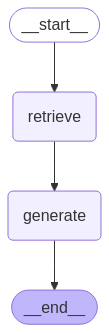

In [40]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [41]:
result = graph.invoke({"question": "When did the second Trump administration impose an immediate freeze on research grants, communications, hiring, and meetings at the National Institutes of Health?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(metadata={'title': '2025 in science - Wikipedia', 'source': 'https://en.wikipedia.org/wiki/2025_in_science', 'language': 'en'}, page_content='The exoplanet WASP-127b is discovered to have wind speeds of up to 33,000 km/h, the fastest jetstream of its kind ever measured.[20]\n22 January – The second Trump administration imposes an immediate freeze on scientific grants, communications, hiring, and meetings at the National Institutes of Health (NIH) – by far the biggest supporter of biomedical research worldwide – impacting $47.4 billion worth of activities.[21]\n23 January'), Document(metadata={'source': 'https://en.wikipedia.org/wiki/2025_in_science', 'language': 'en', 'title': '2025 in science - Wikipedia'}, page_content='^ "Trump hits NIH with \'devastating\' freezes on meetings, travel, communications, and hiring". Science. 22 January 2025. Retrieved 24 January 2025.\n\n^ "Strong as steel, light as foam: Machine learning and nano-3D printing create breakthrough nan

# ## 🧪 Schritt 5: Beispiel-Dialog

In [33]:

fragen = [
    "When did the second Trump administration impose an immediate freeze on research grants, communications, hiring, and meetings at the National Institutes of Health?",
    "How much of the institute's operations were affected by this decision?",
    "When did astronomers report the discovery of Saturn's new moons?",
    "Which countries' telescopes were used? How many new moons of Saturn were discovered?",
    "What is the total number of confirmed satellites of Saturn currently known?" 
]

for frage in fragen:
    #retrieved_docs = retriever.get_relevant_documents(frage)
    antwort = rag_chain.run(frage)
    print(f"\n🙋 Frage: {frage}\n🤖 Antwort: {antwort}")
    #print(f"\n🙋 Frage: {frage} \n  Anzahl gefundener Dokumente: {len(retrieved_docs)}\n {retrieved_docs[0].page_content[:500]}\n🤖 Antwort: {antwort}")


🙋 Frage: When did the second Trump administration impose an immediate freeze on research grants, communications, hiring, and meetings at the National Institutes of Health?
🤖 Antwort: Die zweite Trump-Regierung hat am 22. Januar 2025 einen sofortigen Stopp für Forschungsstipendien, Kommunikationen, Einstellungen und Treffen an den National Institutes of Health verhängt.

🙋 Frage: How much of the institute's operations were affected by this decision?
🤖 Antwort: Das Dokument erwähnt, dass die Vereinten Nationen das Jahr 2025 zum Internationalen Jahr der Quantenwissenschaft und -technologie erklärt haben. Es enthält jedoch keine Informationen darüber, wie sich diese Entscheidung auf die Abläufe eines Instituts ausgewirkt hat.

🙋 Frage: When did astronomers report the discovery of Saturn's new moons?
🤖 Antwort: Astronomen meldeten die Entdeckung von 128 neuen Saturnmonden am 11. März 2025.

🙋 Frage: Which countries' telescopes were used? How many new moons of Saturn were discovered?
🤖 Antw